# Tensim BAS simulation code
Translated to Python by: Ayush Tripathi (ayushtripathi0905@gmail.com)\
Modified by: Om Guin (om.guin@gmail.com)

In [2]:
# simulation imports
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from numpy import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve
from scipy.signal.windows import gaussian
import os
from datetime import datetime
import json

In [3]:
# Update when code is revised
versionnum = 'v1p9p3'

## Functions

### Sample Gaussian-Lorentzian beam shape and display

In [4]:
def GLbeam(z, y, w0, zR, yfactor, zfactor):
  # sample GL beam shape
  wlor2 = (w0**2)*(1+np.square(np.divide(z, zR))) # Lorentzian component
  B = np.multiply((np.divide(w0**2, wlor2)), np.exp(-2*(np.divide(np.square(y), wlor2))))
  return B

### Sample Gaussian beam shape and display

In [5]:
def Gbeam(z, y, w0, zR, yfactor, zfactor):
  # sample Gaussian beam shape
  B = np.multiply(math.exp(-2*(np.divide(np.square(y), (w0**2)))), math.exp(-2*(np.divide(np.square(z), (zR**2)))))
  return B

### Histogram of Beam Shape

In [6]:
def HistoBeam(B):
    """
    Display histogram of beam shape.
    Assume values of B normalized from 0 to 1.
    Bin data down to 0.5% with 30 bins.
    Superimpose a power law model of spectral index powern.
    """

    B_flat = B.flatten()

    edgemn = np.log10(0.005 * np.max(B_flat))
    edgemx = np.log10(np.max(B_flat))
    logedge = np.logspace(edgemn, edgemx, 30)

    n, edges = np.histogram(B_flat, bins=logedge)

    plt.figure()
    plt.loglog(logedge[:-1], n, '-ro', label='Beam Histogram')
    plt.xlabel('Amplitude')
    plt.ylabel('Number Events')

    # over plot a basic powerlaw model with index of powern as expected
    powern = -0.4

    a = n[0]
    b = logedge[0] ** powern
    powerlaw_model = (a / b) * (logedge[:-1] ** powern)
    plt.loglog(logedge[:-1], powerlaw_model, '-bx', label='Powerlaw Model')

    subtitle = f"Fit Powerlaw of index: {powern}"
    plt.title("Model Composite Beam Amplitude Histogram\n" + subtitle)
    plt.legend(loc='upper right')

    # Show plot
    plt.show()

    return 1

### Histogram of Time Stream Burst Amplitudes

In [7]:
def HistoAmp(B):
    """
    Display histogram of time stream data amplitudesl just like HistoBeam except with logedge manually set to generate simulated cummulative data for DL studies (24 Nov 2023).
    Values of B normalized by "Generate starting amplitude distributions and fraction for each species" section.
    Set bin data down to 0.5% with 30 bins.
    Superimpose a power law model of spectral index powern for reference.
    Fix for zeroes at end - extend max even further to "catch" everything.
    Make sure it is adjusted for number of bins, should extend past that
    """
    Nlogedge = 20  # dimension of cumm vectors / number of log bins between edgemn and edgemx

    edgemn = 0.9982
    edgemx = 3.5
    logedge = np.logspace(edgemn, edgemx, Nlogedge)  # fixes logedge from 10 to 3162.3; last bin from edgemx(N-1) to edgemx(N)

    # Compute histogram
    n, edges = np.histogram(B.flatten(), bins=logedge)

    # Plot histogram
    plt.figure()
    plt.loglog(logedge[:-1], n, '-ro', label='Amplitude Histogram')  # used lowest edge of bin as bin intensity value to match dim of histogram
    plt.xlabel('Amplitude')
    plt.ylabel('Number Events')

    # Overplot a basic power law model with index of powern as expected
    powern = -0.4
    a = n[0]
    b = (logedge[0]) ** powern
    powerlaw_model = (a / b) * (logedge[:-1] ** powern)
    plt.loglog(logedge[:-1], powerlaw_model, '-bx', label='Powerlaw Model')

    subtitle = f"Fit Powerlaw of index: {powern}"
    plt.title(f"Model Composite Time Stream Amplitude Histogram\n{subtitle}")
    plt.legend(loc='upper right')

    plt.show()
    is_decreasing = np.all(np.diff(n) <= 0)
    print(is_decreasing)
    
    cumm_heights = n
    return cumm_heights


### Convert binned data (+noise) to photon TOAs using 'intra-bin' poisson process 

In [8]:
def binwise_photon_toas(ampstreams, sampletime_sec, clock):
    """
    Given an amplitude stream (photons per bin), return a flat list of photon arrival times randomly distributed within each bin.
    """
    toas_matrix = []
    n_bins, n_files = ampstreams.shape

    for file_idx in range(n_files):
        toas = []
        for bin_idx in range(n_bins):
            n_photons = int(round(ampstreams[bin_idx, file_idx]))
            if n_photons > 0:
                bin_start = bin_idx * sampletime_sec
                times_in_bin = np.random.uniform(0, sampletime_sec, size=n_photons)
                times = bin_start + times_in_bin
                toas.extend(times/clock)
        toas_matrix.append(np.sort(np.array(toas)))
    
    max_len = max(len(arr) for arr in toas_matrix)
    padded_matrix = np.zeros((max_len, n_files))
    for i, arr in enumerate(toas_matrix):
        padded_matrix[:len(arr), i] = arr
    
    return padded_matrix

### Outputs code version information

In [9]:
def Information(versionnum):
  # Display version and hold introductory information

  simfile = 'TentSim_' + versionnum
  tstr = datetime.now() # time in UTC (4 hours ahead)
  formatted_tstr = tstr.strftime('%d%b%y-%H%M%S')

  print('version number: ' + versionnum)
  print('Version information and details of modeling at bottom of code')
  return simfile, formatted_tstr

## Part 1

Part 1 of this code will use a Gaussian-Lorentzian beam model to simulate a series of burst distribution timestreams based on various experimental parameters. The simulated data is stored in a format consistent with raw microscope data files generated in the past (Header + Ascii columns).

In [10]:
NA = 1 #Effective numerical aperture
lam1 = 5.6e-7 # wavelength (m)
lam2 = 6e-7 # wavelength (m)
zRscale = 3 # unitless factor to elongate z

# to simulate elongation of GL beam. this is a guess right now and not optimizes.
# getting this number wrong means the effective concentration will be off.

# Set scanning and sampling time of instrument
scanrate  = 0.0005 # optical scan rate m/s {500 um/s}
sampletime = 0.0005 # time bin size (seconds) {500 us/sample}


### Set exictation beam and dataset parameters
average concentration, resulting number of data points, samplong, scan speed, etc.

Allow for two color channel (16 Sep 2020)

In [ ]:
#BAS beam parameters
# Using Abbe limit: w0 = lamba/(2*NA) ~lambda/2.9
w0_1 = lam1/(2*NA)
w0_2 = lam2/(2*NA)

# A few geometrical excitation volume estimators for reference (not critical)
zR1 = zRscale*(math.pi*(w0_1**2)/lam1) # scaled Raleigh range
zR2 = zRscale*(math.pi*(w0_2**2)/lam2) # scaled Raleigh range

V_GL1 = ((math.pi**2)*(w0_1**2)*zR1/4) # unsaturated volume for GL beam - not used
V_GL2 = ((math.pi**2)*(w0_2**2)*zR2/4) # unsaturated volume for GL beam - not used

A_GL1 = 2*w0_1*zR1 # approx cross-sectional area in m^2; this underestimates actual detected events by a significant factor when sensitivity extends down to 0.01*max as is assumed
A_GL2 = 2*w0_2*zR2

# Set experimental conditions for time and particle concentration
filetime = 10 # total data file time in seconds (per single file)
particlecon = 7e-10 # average total ensemble Molar concentration; change filename


partperm3 = particlecon*1000*6.023e23 # particles per m^3 based on concentration
effpartspacing = (1/partperm3)**(1/3) # est. space between particles in meters based on concentration

# Physical width/length of one sample in meters
samplewidth = scanrate*sampletime # meters/sample
numbersamples = filetime/sampletime # samples
totalwidth = samplewidth*numbersamples # total scan length in meters

# Estimate of sample volume in one sample
effvolsample1 = A_GL1*scanrate*sampletime # est. rectangular volume m^3 of one sample during scan in x direction; this may not be same size as effective beam volume
effvolsample2 = A_GL2*scanrate*sampletime

approxpartpersamp1 = effvolsample1*partperm3 # estimate of fraction # particles per sample (not per beam volume)
# keep in mind detection limit is beyond effective beam volume by quite a bit so more particle strikes detected than this number (accounted for later by scaling)
approxpartpersamp2 = effvolsample2*partperm3

# Use the avg fraction of particles per sample and total time to estimate the number of bursts to simulate within one effective GL beam volume
# This will be scaled up based on user settings later. The scaling of number goes as the square of the wavelength ratio for Gaussian approximation
neventsamples1 = round(filetime/sampletime*approxpartpersamp1) # estimated # detected in time
neventsamples2 = round(filetime/sampletime*approxpartpersamp2)

out1 = 'Simulating ' + str(neventsamples1) + ' significant bursts within primary volume in ' + str(int(filetime/sampletime)) + ' sample bins...'
print(out1)

out2 = 'Simulating ' + str(neventsamples2) + ' significant bursts wthin primary volume in ' + str(int(filetime/sampletime)) + ' sample bins...'
print(out2)

# Check that there is no where near as many events as bins (single particle limit as needed for BAS). Chosing 10x as cutoff
if (filetime/sampletime) < (10*neventsamples1) or (filetime/sampletime) < (10*neventsamples2):
  print("Too concentrated to preserve single particle requirement. Adjust code.")

Simulating 1558 significant bursts within primary volume in 20000 sample bins...
Simulating 1788 significant bursts wthin primary volume in 20000 sample bins...


### Generate beam crossing ampltiudes & set number of sim files

Display GL Beam Profile Model and generate beam crossing amplitudes for the given experiment parameters. These represent crossing amplitudes of all events but we will subdivide these into different particle distributions. Each file constrained have the same number of bursts so not truly sampling noise with repeats.

In [13]:
# Select number of runs (same sample run again) and repeats (fresh sample) for writing data files
runfiles = 3 # must be an integer from 1-20; max of 20 run files is hardwired
repeatfiles = 2 # must be an integer from 1-20; max of 20 repeats is hardwired

totfiles = runfiles*repeatfiles
print("Number of runs of same sample: " + str(runfiles))
print("Number of repeats with fresh sample: " + str(repeatfiles))
print("Number of sim files generated: " + str(totfiles))

Number of runs of same sample: 3
Number of repeats with fresh sample: 2
Number of sim files generated: 6


In [14]:
# Factor by which to expand sampling volume; same for both channels
# Set these so that model beam amplitude histogram fits powerlaw down to a value of 1/Dynrange
zfactor = 3.5 # z-axis sample half range (m); must be between 1 and 20, inclusive
yfactor = 2.5 # y-axis laterial sample half range (m); must be between 1 and 20, inclusive

Dynrange = 200 # Usable dynamic range of intensity measurement; must be between 1 and 1000, inclusive

# determine number of sample points for scaled volume Color A
scaledvol1 = (2*zR1*zfactor)*(2*w0_1*yfactor)*totalwidth # scaled total scan volume to sample in m^3
nsamples1 = round(scaledvol1/(effpartspacing**3)) # est. of number of samples needed in rectangular

# scaledvol; this should be over-estimate by at least zfactor*yfactor
# compared to number needed as set by estimate above. This will serve as a library of possible events to draw from.
print("Number of event samples in one run of specified volume of simulated data: " + str(nsamples1))

# determine number of sample points for scaled volume Color B
scaledvol2 = (2*zR2*zfactor)*(2*w0_2*yfactor)*totalwidth # scaled total scan volume to sample in m^3
nsamples2 = round(scaledvol2/(effpartspacing**3)) # est. of number of samples needed in scaledvol
print("Number of event samples in one run of specified volume of simulated data: " + str(nsamples2))

# Whichever channel requires more sampling, use that to set number of points to sample. Excess sampling in more narrow beam will be <0.005*max value and discarded later
if neventsamples1 >= neventsamples2:
  nsamples = nsamples1; # number for oversampling
  neventsamples = neventsamples1; # number actually needed to sample to match concentration
  w0 = w0_1
  zR = zR1
else:
  nsamples = nsamples2;
  neventsamples = neventsamples2; # number actually needed to sample to match concentration
  w0 = w0_2
  zR = zR2

# Sanity check that there is enough beam sampling about to happen to fill the estimated needed number of events, neventsamples, found above
if min(neventsamples1, neventsamples2) > nsamples:
  print("Not enough data generated in random beam sampling for this choice of time & sampling. Adjust code")

Number of event samples in one run of specified volume of simulated data: 27259
Number of event samples in one run of specified volume of simulated data: 31292


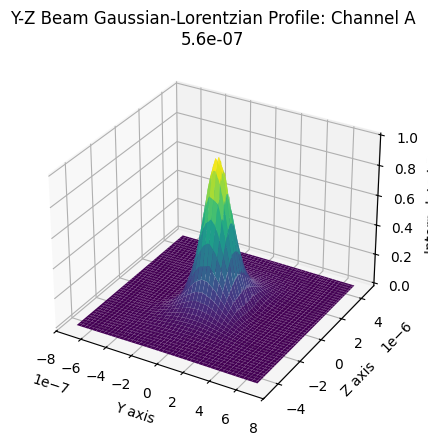

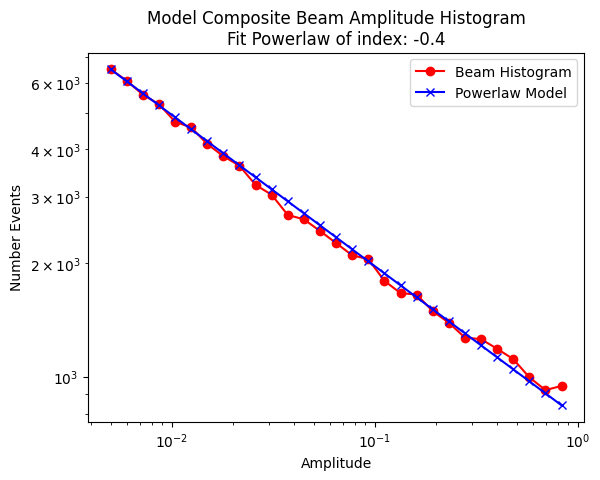

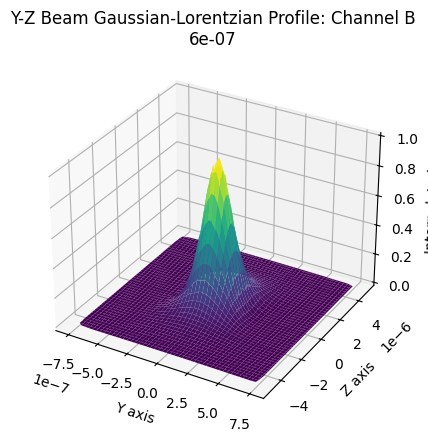

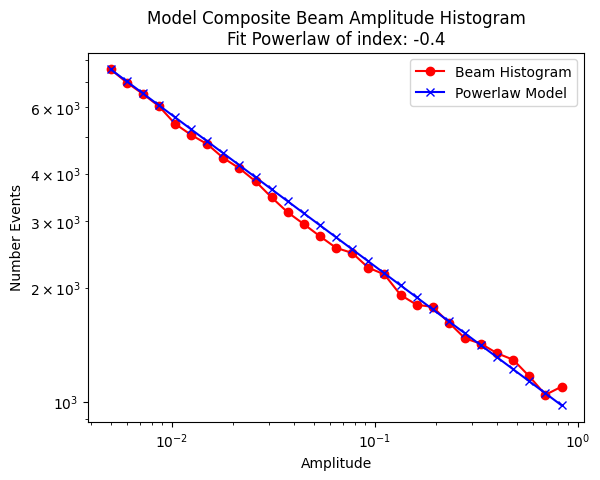

In [15]:
# Sample same regions of space for both channels then discard events below set Dynamic range threshold (typical 0.005*max)

# nsamples of (y, z) pairs with random placement in rectangular region set by larger beam
# Easier than sampling region based on GL shape.
# Shouldn't matter as long as enough sampling happens to generate values down to ~0.005, where the beam shape model is no longer valid

z = (-1+2*random.rand(nsamples, totfiles))*zfactor*zR # centered about value of 0
y = (-1+2*random.rand(nsamples, totfiles))*yfactor*w0 # centered about value of 0

for chan in range(2):

  # note: neventsamples is only meant as an estimate to correct number of detected bursts for a given concentration, Doesn't account for detector threshold set in analysis, etc.
  if chan == 0:
    w0 = w0_1
    zR = zR1;
    plottitle = "Y-Z Beam Gaussian-Lorentzian Profile: Channel A\n" + str(lam1)
  else:
    w0 = w0_2
    zR = zR2
    plottitle = "Y-Z Beam Gaussian-Lorentzian Profile: Channel B\n" + str(lam2)

  #Sample each model with spatial points determined above by larger beam
  BGL = GLbeam(z, y, w0, zR, yfactor, zfactor);

  # Model experimental beam using a Gaussian-Lorentzian power law
  # semi-emperical - seems to work though
  BeamIndex = 2.1 # must be from 1 to 3; use 2.1 for BGL beam
  BGL = BGL/np.max(BGL) # Force Normalize to 1
  B = np.power(BGL, BeamIndex)

  # Display composite beam shape
  # Interpolate to show a surface plot of beam
  znodes = np.arange(-zfactor * zR, zfactor * zR + zR * 0.01, zR * 0.01)
  ynodes = np.arange(-yfactor * w0, yfactor * w0 + w0 * 0.01, w0 * 0.01)

  # Grab 10000 random points to interpolate cause its faster
  plotpnts = np.random.randint(0, B.shape[0], 10000)
  points = np.column_stack((y[plotpnts, 0], z[plotpnts, 0]))

  Y, Z = np.meshgrid(ynodes, znodes)
  grid_points = np.column_stack((Y.ravel(), Z.ravel()))
  zgrid = griddata(points, B[plotpnts, 0], grid_points, method='linear')

  zgrid = zgrid.reshape(Y.shape)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(Y, Z, zgrid, cmap='viridis')

  ax.set_xlabel('Y axis')
  ax.set_ylabel('Z axis')
  ax.set_zlabel('Interpolated B')
  plt.title(plottitle)
  plt.show()
  print("\n\n")

  #Display histogram of resulting model beam shape
  h=HistoBeam(B) # Beam profile normalized to a max value of 1 at this point

  # Each channel has beam model with same number of points sampled in same placed in space but more narrow beam will have more amplitudes <0.005
  #Should see that smaller amplitude events tend to have larger amplitudes in broader beam (e.g. red beam) if simple single species and same max amplitude used for both beams.

  # Now select first neventsamples of the nsamples amplitudes in each beam;
  # Recall neventsamples is estimate of number of burst events for this concentration and beam size (see first part of code)

  if chan == 0:
    B1 = B[0:neventsamples, :]
    z1 = z[0:neventsamples, :]
    y1 = y[0:neventsamples, :]
  else:
    B2 = B[0:neventsamples, :]
    z2 = z[0:neventsamples, :]
    y2 = y[0:neventsamples, :]

  print("\n\n")

### Generate starting amplitude distributions and fraction for each species

Select number of species ns (maximum of 3 for now) and amplitude distribution A subscript i of each.

For each burst event, structure with time, original amp, and beam crossing amp.

Set number of labels for each species to be used to determine color ratio between channels.

Simulated data is in counts so + integer values

In [ ]:
distype = 'flat' # 'flat' is only option for now; '1/n' will be implemented later

match distype:
  case 'flat':
    print("Fixed amplitude species")
    # Amplitudes per label for each species/color channel
    # Make as many samples as possible from 1000 to 2000, just A
    # Amplitudes per label - from 0 to 4096
    AmpS1ChA = 1300 
    AmpS1ChB = 1300
    AmpS2ChA = 1300
    AmpS2ChB = 1300
    AmpS3ChA = 1300
    AmpS3ChB = 1300

    # Species fractions; must be from 0 to 1
    Frac1 = 1
    Frac2 = 0
    Frac3 = 0

    # Number of fluors of each of two colors on a particle; must be from 1 to 10
    LabelNumS1ChA = 1
    LabelNumS1ChB = 1
    LabelNumS2ChA = 4
    LabelNumS2ChB = 4
    LabelNumS3ChA = 7
    LabelNumS3ChB = 7

    # Effectively a normalized mixed ratio
    Frac1n = Frac1/(Frac1+Frac2+Frac3)
    Frac2n = Frac2/(Frac1+Frac2+Frac3)
    Frac3n = Frac3/(Frac1+Frac2+Frac3)
    #cheese
  case '1/N':
    print("To be added later")

# Generate same distribution for each wavelength channel but enforce color
# Labeling factors
for chan in range(2):
  if chan == 0:
    B = B1
  else:
    B = B2

  nB = B[:, 0].size
  p1 = int(np.floor(Frac1n*nB))
  p2 = int(np.floor(p1 + Frac2n*nB))
  p3 = int(np.floor(p2 + Frac3n*nB))

  Bdis = B*0 # initialize

  # scale by number of fluors per molecule
  if Frac1n > 0:
    if chan == 1:
      Bdis[:p1+1, :] = np.multiply(np.multiply(AmpS1ChB, B[:p1+1, :]), LabelNumS1ChB)
    else:
      Bdis[:p1+1, :] = np.multiply(np.multiply(AmpS1ChA, B[:p1+1, :]), LabelNumS1ChA)

  if Frac2n > 0:
    if chan == 1:
      Bdis[p1+1:p2+1, :] = np.multiply(np.multiply(AmpS2ChB, B[p1+1:p2+1, :]), LabelNumS2ChB)
    else:
      Bdis[p1+1:p2+1, :] = np.multiply(np.multiply(AmpS2ChA, B[p1+1:p2+1, :]), LabelNumS2ChA)

  if Frac3n > 0:
    if chan == 1:
      Bdis[p2+1:, :] = np.multiply(np.multiply(AmpS3ChB, B[p2+1:, :]), LabelNumS3ChB)
    else:
      Bdis[p2+1:, :] = np.multiply(np.multiply(AmpS3ChA, B[p2+1:, :]), LabelNumS3ChA)
#species_labels = np.zeros(Bdis.shape[0], dtype=int)
#species_labels[p1+1:p2+1] = 1  # species 2
#species_labels[p2+1:] = 2      # species 3
  if chan == 0:
    Bdis1 = Bdis;
  else:
    Bdis2 = Bdis;


Fixed amplitude species


### Define time of events and amplitudes streams

assume random strike times and all events in channel with least number of strikes occur in other channel

B is of size 4598 by 6, and represents all the sampled impact points in the GL beam.

Bdis is a sectioned off version of B where the first part are the impacts for species 1, second part is for species 2, and third for species 3. The size of these sections is based on the relative concentration of the species.

bindex is of size 4598 by 6 and represents the times from 0 to 120000 at which events occur (randomly sampled)

>>> Working on defining time of events for channel A
Channel 0: Simulated bursts before threshold = 10265
Channel 0: Bursts after threshold = 4404
Number of Channel A events contained in timestream: [710 761 725 744 733 731]
Check histogram of scaled and dynamic range limited data stream before noise and convolved


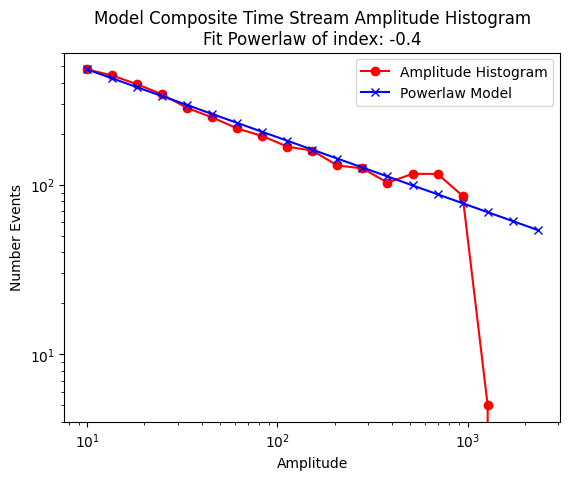

False




>>> Working on defining time of events for channel B
Channel 1: Simulated bursts before threshold = 10265
Channel 1: Bursts after threshold = 5062
Number of Channel B events contained in timestream: [812 875 843 857 838 837]
Check histogram of scaled and dynamic range limited data stream before noise and convolved


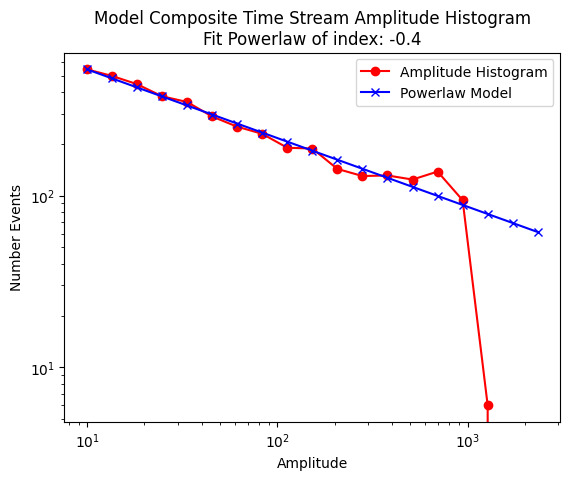

False






In [ ]:
# Use same random event times for both channels. length(Bdis) should equal neventsamples
nsamplebins = round(filetime/sampletime) # number of data points in single data file
bindex = random.randint(0, nsamplebins, size=(neventsamples, totfiles)) # select random indices for burst events in each of the datafiles to create (totfiles)

for chan in range(2):
  if chan == 0:
    print(">>> Working on defining time of events for channel A")
    Bdis = Bdis1
    # use channel with least events to define
  else:
    print(">>> Working on defining time of events for channel B")
    Bdis = Bdis2

  ampstreams = np.zeros((nsamplebins, totfiles))
  for i in range(totfiles):
    ampstreams[np.squeeze(bindex[:, i]), i] = Bdis[:, i]

  # Remove events whos amplitudes are less than 1/Dynrange
  ampstreams[ampstreams < (max(AmpS1ChA, AmpS1ChB, AmpS2ChA, AmpS2ChB, AmpS3ChA, AmpS3ChB)/Dynrange)] = 0

  # Check new number of events
  if chan == 0:
    neventsamp1 = sum(ampstreams>0)
    print("Number of Channel A events contained in timestream: " + str(neventsamp1))
  else:
    neventsamp2 = sum(ampstreams>0)
    print("Number of Channel B events contained in timestream: " + str(neventsamp2))

  if chan == 0:
    ampstreamsA = ampstreams
  else:
    ampstreamsB = ampstreams

  # Recheck histograms
  print("Check histogram of scaled and dynamic range limited data stream before noise and convolved")
  h=HistoAmp(ampstreams)
  print("\n\n\n")


### Convolve to simulate beam width and sampling

The coefficients of a Gaussian window are computed from the following equation: $w(n)=e^{ -\frac{1}{2}\left( \frac{\alpha n}{(L-1)/2} \right)^2 = e^{-n^2/ (2\sigma ^2)}}$ where -(L-1)/2 ≤ n ≤ (L-1)/2, and α is inversely proportional to the standard deviation, σ, of a Gaussian random variable. The exact correspondence with the standard deviation of a Gaussian probability density function is $\sigma=\frac{w0}{2}$ so $\alpha=\frac{(L-1)}{2\sigma}=\frac{(L-1)}{w0}$

The 1/e2 width of the intensity profile is described by $I(r)=I_{0}\exp \!\left(\!-2{\frac {r^{2}}{w^{2}}}\right)$

Adding Gaussian spread to events...


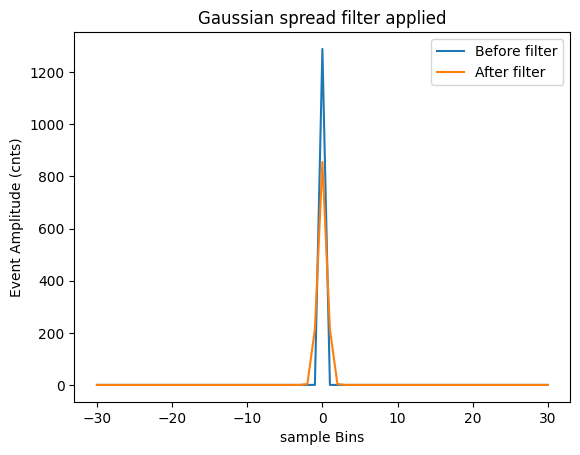

In [18]:
addspread = True  # Set to True to simulate the Gaussian spread for events

if addspread:
    print("Adding Gaussian spread to events...")

    # Display effect
    max_amp = np.max(ampstreams)
    qq = np.unravel_index(np.argmax(ampstreams, axis=None), ampstreams.shape)  # Find index of the maximal event in all runs
    ind_row, ind_col = qq
    bigspikebefore = ampstreams[ind_row-30 : ind_row+31, ind_col]

    L = 7 # Concolve window L samples; 7-15 is reasonable; odd numbers tend to work best

    # For now, use same convolving filter for both channels
    alpha = (L-1)/(w0/(scanrate*sampletime))  # Standardly defined width vector
    alphacorr = 1 # increase spread in time stream of a burst by correction factor (semi-emperical); default is 1.5; increase for larger effect, decrease for smaller

    gfilter = gaussian(L, std=(L-1)/(2*(alpha/alphacorr)))

    # Normalize the Gaussian filter to ensure it leaves event peaks with the same amplitudes but adds Gaussian spread
    gfilter /= np.sum(gfilter)

    # Convolve each column in ampstreams with the Gaussian filter
    ampstreams_convolved = np.copy(ampstreams)
    ampstreamsA_convolved = np.copy(ampstreamsA)
    ampstreamsB_convolved = np.copy(ampstreamsB)
    for i in range(ampstreams.shape[1]):
        ampstreams_convolved[:, i] = convolve(ampstreams[:, i], gfilter, mode='same')
        ampstreamsA_convolved[:, i] = convolve(ampstreamsA[:, i], gfilter, mode='same')
        ampstreamsB_convolved[:, i] = convolve(ampstreamsB[:, i], gfilter, mode='same')
    # Display effect (window of +/- 30 for display purpose only)

    x_values = np.arange(-30, 31)
    ampstreams = ampstreams_convolved
    ampstreamsA = ampstreamsA_convolved
    ampstreamsB = ampstreamsB_convolved
    bigspikeafter = ampstreams[ind_row-30 : ind_row+31, ind_col]
    plt.figure()
    plt.plot(x_values, bigspikebefore, label='Before filter')
    plt.plot(x_values, bigspikeafter, label='After filter')
    plt.xlabel('sample Bins')
    plt.ylabel('Event Amplitude (cnts)')
    plt.title('Gaussian spread filter applied')
    plt.legend()
    plt.grid(False)
    plt.show()


### Add Noise (Not tested)

In [19]:
bkgrndnoise = "Poisson" # @param ["None", "Poisson", "Gaussian", "Offset"]

In [20]:
match bkgrndnoise:
  case 'Poisson':
    print("Adding baseline Poisson noise ChA")
    lambdaA = 15 # 15 is default; should be from 0-100
    noiseamp = random.poisson(lambdaA, ampstreamsA.shape) #ampstreamsA[:, 1].shape[0] gives amount of rows, len(ampstreamsA[1]) (1D arrays do not have a .shape[0] attribute and so you need to get a length) returns columns but ampstreamsA.shape returns rows and columns, combining both of those functions
    ampstreamsA = ampstreamsA+noiseamp

    print("Adding baseline Poisson noise ChB")
    lambdaB = 15 # 15 is default; should be from 0-100
    noiseamp = random.poisson(lambdaB, ampstreamsB.shape)
    ampstreamsB = ampstreamsB+noiseamp

  case 'Offset':
    print("Adding constant offset value ChA")
    sigoffsetA = 15 # 15 is default; should be from 0-100
    ampstreamsA = ampstreamsA+sigoffsetA

    print("Adding constant offset value ChB")
    sigoffsetB = 15 # 15 is default; should be from 0-100
    ampstreamsB = ampstreamsB+sigoffsetB

  case 'Gaussian':
    print("Adding baseline Gaussian noise ChA")
    meanA = 10 # 10 is default; should be from 0-50
    sigmaA = 3 # 3 is default; should be from 0-20
    noiseamp = random.normal(meanA, sigmaA, ampstreamsA.shape)
    ampstreamsA = ampstreamsA+noiseamp
    ampstreamsA[ampstreamsA < 0] = 0

    print("Adding baseline Gaussian noise ChB")
    meanB = 10 # 10 is default; should be from 0-50
    sigmaB = 3 # 3 is default; should be from 0-20
    noiseamp = random.normal(meanB, sigmaB, ampstreamsB.shape)
    ampstreamsB = ampstreamsB+noiseamp
    ampstreamsB[ampstreamsB < 0] = 0

signoiseB = 'None' # Options: 'None' or 'Shot'; same noise values added on each rerun of code
match signoiseB:
  case 'Shot':
    print("Adding shot noise ChB: var = mean count")
    for i in range(totfiles):
      noiseamp = random.poisson(ampstreamsB[:, i])
      ampstreamsB[:, i] = noiseamp.squeeze()

print(ampstreamsA)
print(ampstreamsB)

Adding baseline Poisson noise ChA
Adding baseline Poisson noise ChB
[[ 16.         127.86835959  12.          11.          17.
   15.        ]
 [ 13.          44.89203139  10.          11.          12.
   14.        ]
 [ 20.          14.44793782   9.          15.          13.
    9.        ]
 ...
 [ 11.          17.13161662  14.          15.           9.
   15.440417  ]
 [ 16.          24.55900893  10.          12.          11.
   14.00042455]
 [ 18.          21.13161662  18.          26.          13.
   15.        ]]
[[ 20.         161.00386101  14.          13.          19.
   14.        ]
 [ 19.          58.65573744  12.          14.          16.
   16.        ]
 [  9.          21.56830519  14.          10.          12.
   23.        ]
 ...
 [  6.          18.36423628  12.          21.          17.
   13.52792706]
 [ 15.          26.50229645  18.          12.          17.
   17.00050891]
 [ 26.          19.36423628  15.          15.          12.
   14.        ]]


### Apply species dynamics (TBD)

In [21]:
dynam = "none" # @param ["none", "random break", "random bind"]

### Check Inter-event interval to see if consistent with random event arrivals

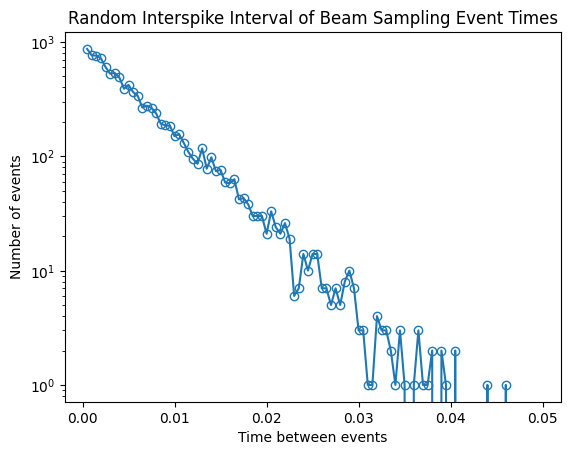

In [22]:
checkisi = True
# This works in continuous limit but if sampling time is on the order of or larger than mean event time this will not work.
# In this case, you need to set an amplitude threshold to limit number of events considered.
# Since the beam model is only valid to, say, 1% consider only events larger than 1% of the maximum amplitude.

if checkisi:
  # Check interspike interval using all events; first bin will be overloaded due to limit of bin size
  striketimesm = random.randint(1, ampstreams.ravel().shape[0], size=(bindex.ravel().shape[0], 1))
  rtm = np.sort(striketimesm, axis=0) # chronological order of event bins
  peakshm = np.roll(rtm, 1)
  peakdiffm = rtm - peakshm

  # For reference, model of single population distribution with same avg event rate
  # If multiple species, events should still be uncorrelated like 1 species of higher rate
  nhistbins = 100 # consider sampletime*nhistbins seconds of event spacing (typically 100 ms)
  xoutm = np.arange(1, 101)
  nm, _ = np.histogram(peakdiffm[2:-1], bins=xoutm) # hist of random samples for control
  plt.semilogy(xoutm[:-1] * sampletime, nm, '-o', markerfacecolor='none')
  plt.title('Random Interspike Interval of Beam Sampling Event Times')
  plt.xlabel('Time between events')
  plt.ylabel('Number of events')
  plt.show()


### Allow time stream runs to be added to simulate higher concentration (TBD)
Increasing concentration at start is limited by sample binning and uniform random distribution: doesn't yeild corect high concentration behavior. Allow co-adding all run files.

In [23]:
coadd = False
# adds together all runfiles for a single repeat into one of same length
# Like adding signal prerounding to integer; binning still discrete and coadding doesn't account for thise (very simple method)

if coadd and (runfiles > 1):
  nampstreams = np.zeros((ampstreams[:, 1].shape[0], repeatfiles)) # initialize new coadded

  for j in range(repeatfiles):
    tempamp = ampstreams[:, (j)*runfiles: (j+1)*runfiles]
    nampstreams[:, j] = np.sum(tempamp, 1)

  runfiles = 1
  ampstreams = nampstreams


### Convert binned data (+noise) to photon TOAs using 'intra-bin' poisson process 

In [24]:
artificial_clock = 82.31e-12
toasA = binwise_photon_toas(ampstreamsA, sampletime, artificial_clock)
toasB = binwise_photon_toas(ampstreamsB, sampletime, artificial_clock)
print(toasA.shape)
print(toasB.shape)

(392286, 6)
(406230, 6)


### Write simulated data to a series of files
Include header similar to thise example:


---
*3/30/2020  11:39 AM*

*Total aquisition time: 60.92 sec*

*MT Clock: 82.31 psec*

*Bin width for correlator intensity data: 500.00 usec*

*Scan diameter: 0.40 mm*

*Scan speed: 0.50 mm/sec*

*Lasers Active: 488 @ 0.050 mW*

*Laser modulation not active*

*Notes:*

*1/400000 dilution of 40 nm GreenFS in miliQ water*

***end header***

Corr_I_A          Corr_I_B





---

Data follows in 2 column integer text with tab seperation: *blue # coln   red # coln *


In [25]:
# Simulation parameters
savefiles = True

if savefiles:
    data_dir = "sim_data"
    os.makedirs(data_dir, exist_ok=True)

    simfile, timestr = Information(versionnum)
    newdir = os.path.join(data_dir, f"{simfile}_{timestr}")
    os.makedirs(newdir, exist_ok=True)


    GT = {
        "Amplitudes":{
            "AmpS1ChA": AmpS1ChA,
            "AmpS1ChB": AmpS1ChB,
            "AmpS2ChA": AmpS2ChA,
            "AmpS2ChB": AmpS2ChB,
            "AmpS3ChA": AmpS3ChA,
            "AmpS3ChB": AmpS3ChB
        },
        "SpeciesFractions": {
            "Frac1": Frac1,
            "Frac2": Frac2,
            "Frac3": Frac3
        },
        "LabelNumbers": {
            "LabelNumS1ChA": LabelNumS1ChA,
            "LabelNumS1ChB": LabelNumS1ChB,
            "LabelNumS2ChA": LabelNumS2ChA,
            "LabelNumS2ChB": LabelNumS2ChB,
            "LabelNumS3ChA": LabelNumS3ChA,
            "LabelNumS3ChB": LabelNumS3ChB
        }
    }
    
    with open(os.path.join(newdir, f"{timestr}-GROUND_TRUTH.json"), 'w') as f:
        json.dump(GT, f, indent=4)

    # Stores a parameters file with all runfile names for use with Tentsim_Preprocess.mlx
    
    filenameparam = os.path.join(newdir, f"{timestr}-preparams.par")

    k = 0
    # Opens parameter file for writing
    with open(filenameparam, 'w') as fileIDparam:

        fileIDparam.write('%%%% (maintain 5 header lines) \n')
        fileIDparam.write('These data represent simulated data with 3 independent populations \n')
        fileIDparam.write(f'These header lines can be used to explain the point of the data collection \n')
        fileIDparam.write('and point to other informative files with additional information. \n')
        fileIDparam.write('%%%% \n\n')


        for i in range(1, repeatfiles + 1):
            for j in range(1, runfiles + 1):

                # Write a data file (w/o newdir prefix) for each run into the preparam file
                
                filenamedat = f"{timestr}-{i}-{j}.txt"

                # Add file name to preparam file
                fileIDparam.write(filenamedat + '\n')

                # Store data file into new dir for each run in a specific file in the new directory
                filename = os.path.join(newdir, filenamedat)

                # Open data file for writing
                with open(filename, 'w') as fileID:

                    # TAMU style header
                    fileID.write(f'{timestr}\n\n')
                    fileID.write('Total acquisition time: 1200 sec \n')
                    fileID.write('MT Clock: 1 sec\n')
                    fileID.write('Bin width for correlator intensity data: 500.00 usec \n')
                    fileID.write('Scan diamater: 0.40 mm \n')
                    fileID.write('Scan speed: 0.50 mm/sec \n')
                    fileID.write('Lasers Active: 488 @ 0.050 mW \n')
                    fileID.write('Laser modulation not active \n')
                    fileID.write('Notes: \n')
                    fileID.write('Simulated data\n')
                    fileID.write('***end header*** \n\n')
                    fileID.write('I_A  I_B \n')
                    

                    # Example simulated data (using toasA and toasB)
                    colA = np.round(toasA[:, k]).astype(int)
                    colB = np.round(toasB[:, k]).astype(int)

                    max_len = max(len(colA), len(colB))
                    paddedA = np.pad(colA, (0, max_len - len(colA)), constant_values=0)
                    paddedB = np.pad(colB, (0, max_len - len(colB)), constant_values=0)
                    
                    outdat = np.column_stack((paddedA, paddedB))

                    for row in outdat:
                        fileID.write(f"{row[0]}\t{row[1]}\n")

                    k = (k+1)


    with open(filenameparam, 'a') as fileIDparam:
        fileIDparam.write('\n')
        fileIDparam.write('datatype TotTime MTclock bintime driftwinA driftwinB driftwinC threshA threshB threshC corrt dofit colA colB colC\n')
        formatSpec = '%d %f %.2e %.6f %d %d %d %d %d %d %.3f %d %d %d %d\n'
        fileIDparam.write(formatSpec % (1, filetime, artificial_clock, sampletime, 0, 0, 0, 1, 1, 1, 0.003, 1, 1, 2, 0))

    print("Files saved successfully.")

version number: v1p9p3
Version information and details of modeling at bottom of code
Files saved successfully.
